# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout, Flatten, BatchNormalization, Dense, MaxPooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, Adamax, RMSprop
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


# Extract Data From Dataset

In [2]:
fldr='./UTKFace'

In [3]:
import os
files = os.listdir(fldr)

# Sepreting Result By Ages, Genders, Images Wise

In [6]:
ages=[]
genders=[]
images=[]

for fl in files:
    age = int(fl.split('_')[0])
    gender = int(fl.split('_')[1])
    total = fldr+'/' + fl
    print(total)
    image = cv2.imread(total)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(48,48))
    images.append(image)
    ages.append(age)
    genders.append(gender)

"ages=[]\ngenders=[]\nimages=[]\n\nfor fl in files:\n    age = int(fl.split('_')[0])\n    gender = int(fl.split('_')[1])\n    total = fldr+'/' + fl\n    print(total)\n    image = cv2.imread(total)\n    \n    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)\n    image = cv2.resize(image,(48,48))\n    images.append(image)\n    ages.append(age)\n    genders.append(gender)"

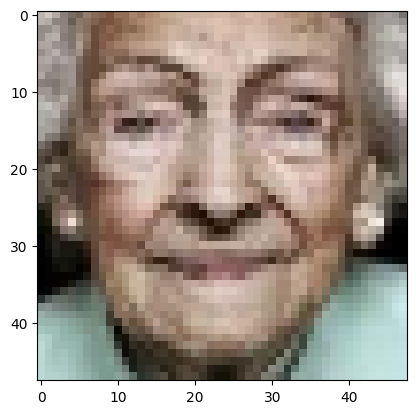

In [8]:
plt.imshow(images[7])

In [9]:
ages[7], genders[7]

(100, 1)

# Saving Images, Ages, Genders Array In System

In [10]:
images_f = np.array(images)
ages_f = np.array(ages)
genders_f = np.array(genders)

In [11]:
np.save(fldr+'images1.npy',images_f)
np.save(fldr+'ages1.npy',images_f)
np.save(fldr+'gemders1.npy',images_f)

# Finding The No. of Male and Female samples

In [12]:
np.unique(genders_f, return_counts=True)[1]

array([12391, 11317], dtype=int64)

# Plotting The No. Of Male And Female Samples

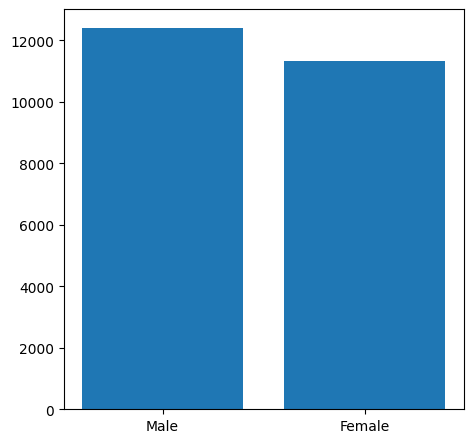

In [13]:
fig = plt.figure(figsize = (4,4))
ax = fig.add_axes([0,0,1,1])
gender=['Male', 'Female']
values=[12391, 11317]
ax.bar(gender, values)
plt.show()

In [15]:
counts = np.unique(ages_f, return_counts=True)[1].tolist()

# Plotting The samples Age Wise 

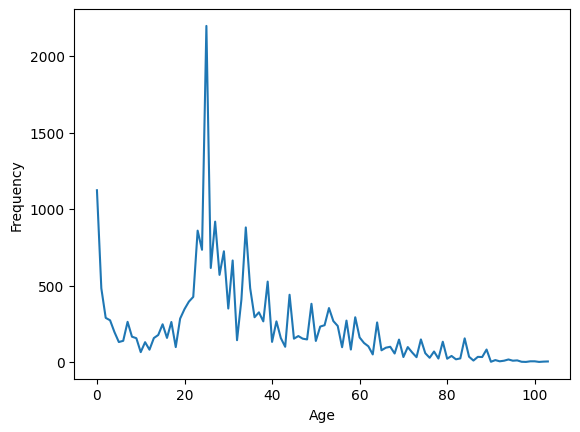

In [16]:
plt.plot(counts)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Defining a Lebals For Output

In [17]:
labels = []
i = 0
while i < len(ages):
    label = []
    label.append(ages[i])
    label.append(genders[i])
    labels.append(label)
    i+=1

# Creating List Of Images

In [18]:
images_f_2 = images_f/255
images_f_2.shape

(23708, 48, 48, 3)

In [19]:
labels_f = np.array(labels)

In [20]:
len(labels_f)

23708

# Splitting The Dataset using train_test_split method

In [21]:
X_train, X_test, y_train, y_test = train_test_split(images_f_2, labels_f, test_size= 0.25)

In [22]:
X_train.shape, y_train.shape

((17781, 48, 48, 3), (17781, 2))

In [23]:
y_train[:5]

array([[38,  0],
       [35,  0],
       [26,  1],
       [32,  1],
       [35,  0]])

# splitting y_test and y_train for better understanding

In [24]:
y_train_2 = [y_train[:,1],y_train[:,0]]
y_test_2 = [y_test[:,1],y_test[:,0]]

# Defining The Model

In [25]:
def convolution(input_tensor, filters):
    x = Conv2D(filters=filters, kernel_size=(3,3), padding='same', strides=(1,1), kernel_regularizer=l2(0.001))(input_tensor)
    x = Dropout(0.1)(x)
    x = Activation('relu')(x)
    return x

In [26]:
def model(input_shape):
    inputs = Input((input_shape))
    conv1 = convolution(inputs, 32)
    maxp1 = MaxPooling2D((2, 2))(conv1)
    conv2 = convolution(inputs, 64)
    maxp2 = MaxPooling2D((2, 2))(conv2)
    conv3 = convolution(inputs, 128)
    maxp3 = MaxPooling2D((2, 2))(conv3)
    conv4 = convolution(inputs, 256)
    maxp4 = MaxPooling2D((2, 2))(conv4)
    flatten = Flatten()(maxp4)
    dense1 = Dense(64, activation='relu')(flatten)
    dense2 = Dense(64, activation='relu')(flatten)
    drop1 = Dropout(0.2)(dense1)
    drop2 = Dropout(0.2)(dense2)
    output1 = Dense(1, activation='sigmoid', name='sex_out')(drop1)
    output2 = Dense(1, activation='relu', name='age_out')(drop2)
    model = Model(inputs=[inputs], outputs=[output1, output2])
    model.compile(loss=['binary_crossentropy','mae'],optimizer='Adam',metrics={'sex_out': 'accuracy', 'age_out': 'mae'})
    return model

In [27]:
model1 = model((48,48,3))

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Initializng Model

In [30]:
file_s = 'Age_Gender_Detection1.keras'
checkpoint = ModelCheckpoint(file_s, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
Early_stop = tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss', restore_best_weights=True)
callback_list = [checkpoint, Early_stop]

In [31]:
#history = model1.fit(X_train, y_train_2, batch_size=64, validation_data=(X_test, y_test_2), epochs=300, callbacks=callback_list)

Epoch 1/300
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - age_out_mae: 15.3429 - loss: 16.1865 - sex_out_accuracy: 0.6551
Epoch 1: val_loss improved from inf to 10.56910, saving model to Age_Gender_Detection1.keras
278/278 ━━━━━━━━━━━━━━━━━━━━ 118s 416ms/step - age_out_mae: 15.3355 - loss: 16.1781 - sex_out_accuracy: 0.6555 - val_age_out_mae: 10.2064 - val_loss: 10.5691 - val_sex_out_accuracy: 0.8495
Epoch 2/300
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - age_out_mae: 10.5179 - loss: 10.8861 - sex_out_accuracy: 0.8345
Epoch 2: val_loss improved from 10.56910 to 9.95138, saving model to Age_Gender_Detection1.keras
278/278 ━━━━━━━━━━━━━━━━━━━━ 120s 430ms/step - age_out_mae: 10.5170 - loss: 10.8851 - sex_out_accuracy: 0.8345 - val_age_out_mae: 9.6430 - val_loss: 9.9514 - val_sex_out_accuracy: 0.8708
Epoch 3/300
278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - age_out_mae: 9.5633 - loss: 9.8938 - sex_out_accuracy: 0.8519
Epoch 3: val_loss improved from 9.95138 to 9.33507, saving model to Age_G

# Model Evaluation

In [32]:
model1.evaluate(X_test, y_test_2)


186/186 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - age_out_mae: 7.3105 - loss: 7.6990 - sex_out_accuracy: 0.8950


[7.670897006988525, 7.283228397369385, 0.8920195698738098]

In [33]:
pred = model1.predict(X_test)

186/186 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step


In [34]:
pred[0]

array([[9.3407422e-01],
       [4.6255193e-13],
       [9.4956267e-05],
       ...,
       [9.2883551e-01],
       [9.9999583e-01],
       [1.7067593e-06]], dtype=float32)

# Plotting Loss

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Validation'], loc='upper left')
plt.subplots_adjust(top=1, bottom=0, right=0.95, left=0, hspace=0.25, wspace=0.35)

# Plotting Sex Accuracy

In [ ]:
plt.plot(history.history['sex_out_accuracy'])
plt.plot(history.history['val_sex_out_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Validation'], loc='upper left')
plt.subplots_adjust(top=1, bottom=0, right=0.95, left=0, hspace=0.25, wspace=0.35)

# Plotting Gender Accuracy

In [ ]:
fig,ax = plt.subplots()
ax.scatter(y_test_2[1],pred[1])
ax.plot([y_test_2[1].min(), y_test_2[1].max()], [y_test_2[1].min(), y_test_2[1].max()], 'k--', lw=4)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age')
plt.show()

# making the report of the model Gender Only

In [77]:
'''i=0
pred_l=[]
while i<len(pred[0]):
    pred_l.append(int(np.round(pred[0][i])))
    i=i+1'''

'i=0\npred_l=[]\nwhile i<len(pred[0]):\n    pred_l.append(int(np.round(pred[0][i])))\n    i=i+1'

In [72]:
type(pred[0][0][0])

numpy.float32

# Making The Heatmap Of The Model

In [49]:
report = classification_report(y_test_2[0], pred_l)

In [50]:
print(report)

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      3127
           1       0.87      0.91      0.89      2800

    accuracy                           0.89      5927
   macro avg       0.89      0.89      0.89      5927
weighted avg       0.89      0.89      0.89      5927



In [51]:
results = confusion_matrix(y_test_2[0], pred_l)

# Testing Images

In [4]:
def test_image(ind,images_f,images_f_2,Model):
    plt.imshow(images_f[ind])
    image_test=images_f_2[ind]
    pred_l=Model.predict(np.array([image_test]))
    sex_f=['Male','Female']
    age=int(np.round(pred_l[1][0]))
    sex=int(np.round(pred_l[0][0]))
    print("Predicted Age is "+ str(age))
    print("Predicted Gender is "+ sex_f[sex])

In [ ]:
test_image(243,images_f,images_f_2,model1)

In [ ]:
test_image(29,images_f,images_f_2,model1)